# Descrição de Atividade

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).

Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. 

Isso implica, dentre outras coisas:
1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção;
2. Fazer tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso;
3. Construir modelos de regressão com (ridge e lasso) e sem regularização;
4. Considerar também modelos de regressão não paramétrica como KNN;
5. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Forests);
6. Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados;
7. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema;

Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

_**Dica**: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados._

## Responder:
### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

**Sobre os dados**

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

* **sequencial_candidato**:  (character) id do candidato
* **nome**: (character)
* **uf**: (character)
* **partido**: (character)
* **quantidade_doacoes** : (integer)
* **quantidade_doadores**: (integer) numero de doadores diferentes
* **total_receita**: (double) soma em reais das doacoes
* **media_receita**: (double) media das doacoes
* **recursos_de_outros_candidatos_por_comite**: (double) quantia em reais das doacoes provenientes de outros candidatos ou comite partidário
* **recursos_de_pessoas_fisicas**: (double) quantia em reais das doacoes provenientes de outros CPFs
* **recursos_de_pessoas_juridicas**: (double) quantia em reais das doacoes provenientes de outros CNPJ
* **recursos_proprios**: (double) quantia em reais das doacoes provenientes do proprio candidato
* **recursos_de_partido_politico**: (double) quantia em reais das doacoes provenientes do partido politico do candidato
* **votos**: (integer) variavel alvo. Se refere ao numero de votos na campanha de 2006 e 2010
* **quantidade_despesas**: (integer)
* **quantidade_fornecedores**: (integer) numero de fornecedores por despesas diferentes
* **total_despesa**: (double) soma em reais das despesas de campanha
* **media_despesa**: (double) media das despesas de campanha
* **cargo**: (character)
* **sexo**:  (character)
* **grau**: (character) grau de instrucao do candidato
* **estado_civil**: (character)
* **ocupacao**: (character) ocupacao do candidato

## Import Libraries

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style="ticks")

%matplotlib inline

## Load Data

In [131]:
candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')
candidates_df.shape

(7330, 23)

In [132]:
candidates_test_df = pd.read_csv('../data/eleicoes_2014.csv')
candidates_test_df.shape

(4936, 23)

### Remove Colunas Desnecessárias para Análise

In [133]:
candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])
candidates_test_df = candidates_test_df.drop(columns=['sq_candidato', 'nome_candidato'])

### Renomeação de Colunas de Dataset de Testes

In [134]:
candidates_test_df.rename(columns={'sigla_uf':'uf',
                          'sigla_partido':'partido',
                          'qtd_doacoes':'quantidade_doacoes',
                          'qtd_doadores':'quantidade_doadores',
                          'recursos de outros candidatos/comitês':'recursos_de_outros_candidatos_comites',
                          'recursos de pessoas físicas':'recursos_de_pessoas_fisicas',
                          'recursos de pessoas jurídicas':'recursos_de_pessoas_juridicas',
                          'recursos próprios':'recursos_proprios',
                          'qtd_despesas':'quantidade_despesas',
                          'qtd_fornecedores':'quantidade_fornecedores',
                          'descricao_cargo':'cargo',
                          'grau_instrucao':'grau',
                          'descricao_ocupacao':'ocupacao'}, 
                 inplace=True)

## EDA - Exploratory Data Analysis

Inicialmente, devemos fazer uma análise exploratória dos dados para descobrir como eles estão distribuídos, se possuem valores extraordinários (outliers) e se tem alguma correlação mais forte entre si, especialmente com a variável alvo (**votos**).

In [135]:
candidates_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [136]:
candidates_test_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [137]:
candidates_df.describe(exclude=['category', 'object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


In [138]:
candidates_test_df.describe(exclude=['category','object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,4936.0,4936.000000,4936.000000,4.936000e+03,4936.000000,3.191000e+03,3.727000e+03,1.714000e+03,2.860000e+03,4936.000000,4936.000000,4.936000e+03,4936.000000,4.936000e+03
mean,2014.0,24.809765,21.216572,2.005536e+05,6135.051733,3.349950e+04,4.084598e+04,2.036965e+05,4.356332e+04,148.208671,117.088736,2.051600e+05,1345.348445,1.780833e+04
std,0.0,49.980431,40.888475,5.347148e+05,14250.293622,1.139275e+05,1.085905e+05,4.256615e+05,1.757768e+05,441.152375,347.458705,5.537136e+05,1877.675782,4.641931e+04
min,2014.0,1.000000,1.000000,3.000000e-01,0.300000,1.500000e-01,1.000000e-02,1.170000e+00,2.000000e-01,1.000000,1.000000,7.200000e-01,0.720000,0.000000e+00
25%,2014.0,5.000000,4.000000,3.025785e+03,606.562500,1.087750e+03,1.100000e+03,3.000000e+03,1.200000e+03,6.000000,5.000000,3.026463e+03,470.965998,4.740000e+02
50%,2014.0,9.000000,9.000000,1.143493e+04,1416.698571,4.205000e+03,4.500000e+03,2.793599e+04,5.005000e+03,17.000000,15.000000,1.143633e+04,857.971212,1.705500e+03
75%,2014.0,22.000000,19.000000,8.882676e+04,4599.437500,1.921249e+04,2.746000e+04,2.007535e+05,2.183443e+04,72.000000,60.000000,9.013437e+04,1533.463301,1.044750e+04
max,2014.0,928.000000,873.000000,5.836140e+06,281250.000000,1.788100e+06,1.826762e+06,3.828338e+06,3.752000e+06,6413.000000,5170.000000,7.420179e+06,35520.493556,1.524361e+06


A tabela acima já nos permite tirar uma série de insights sobre os dados que temos, entretando precisamos investigar a existência de valores estranhos no nosso dataset, como valores não-numéricos (NaN) em variáveis numéricas:

In [139]:
for col in candidates_df.columns:
    amount_nan = candidates_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [05]: total_receita                            - Amount NaN: 161
Column [06]: media_receita                            - Amount NaN: 161
Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 2390
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 2683
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3976
Column [10]: recursos_proprios                        - Amount NaN: 2388


Faz o mesmo para o dataset de testes

In [140]:
for col in candidates_test_df.columns:
    amount_nan = candidates_test_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_test_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 1745
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 1209
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3222
Column [10]: recursos_proprios                        - Amount NaN: 2076


Para essas variáveis não podemos ter valores não numéricos, então vamos colocar esses valores para 0.0, uma vez que são valores de receita e recursos.

In [141]:
candidates_df.total_receita.fillna(0, inplace=True)
candidates_df.media_receita.fillna(0, inplace=True)
candidates_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_df.recursos_proprios.fillna(0, inplace=True)

Faz o mesmo para os dados de teste

In [142]:
candidates_test_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_test_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_test_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_test_df.recursos_proprios.fillna(0, inplace=True)

### Calculando Skewness de Variáveis Numéricas

Aqui nós transformamos skewed features para que tenham uma distribuição mais normalizada. Ter uma distribuição mais normalizada nos garante um maior arsenal de ferramentas estatísticas e computacionais que podemos utilizar, assim como torna a análise dos dados mais conveniente para nós.

Nós utilizamos o **log(1 + x)** em vez de apenas **log(x)**, uma vez que o log de 0 não existe, e várias de nossas variáveis tem esses valores, como as que preenchemos em substituição a NaN na seção acima. Além disso, como estamos lidando com valores de receita, despesa, etc. é comum ter valores 0 em nossas distribuições.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1faaeeda0>,
      dtype=object)

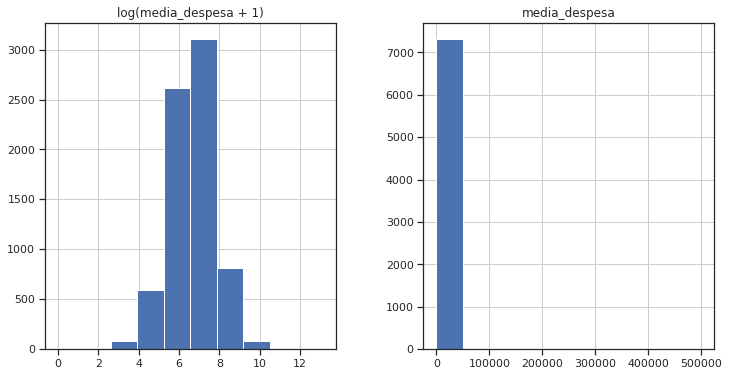

In [143]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
media_despesa = pd.DataFrame({"media_despesa" : candidates_df["media_despesa"], "log(media_despesa + 1)" : np.log1p(candidates_df["media_despesa"])})
media_despesa.hist()

In [144]:
numeric_features = candidates_df.dtypes[candidates_df.dtypes != 'object'].index

skewed_feats = candidates_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print(skewed_feats)

candidates_df[skewed_feats] = np.log1p(candidates_df[skewed_feats])

Index(['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos_comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos'],
      dtype='object')


Importante notar que a variável-alvo **_votos_** também está incluída no conjunto de skewed variables, e não precisa ser transformada em separado.

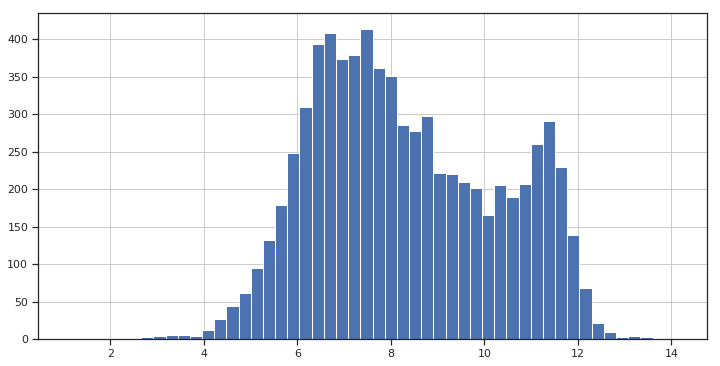

In [145]:
candidates_df.votos.hist(bins=50)

Faz o mesmo para o dataset de testes

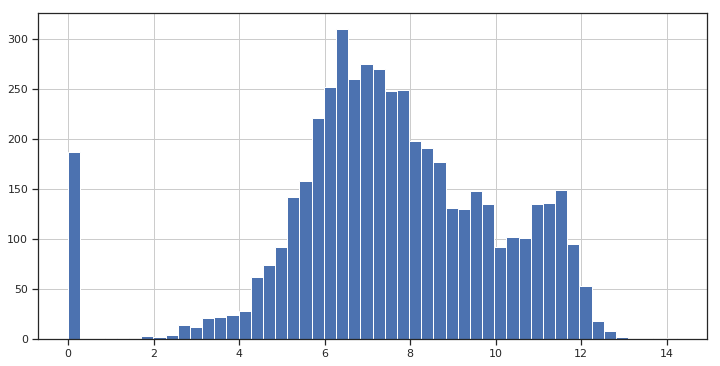

In [146]:
numeric_features = candidates_test_df.dtypes[candidates_test_df.dtypes != 'object'].index

skewed_feats = candidates_test_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

candidates_test_df[skewed_feats] = np.log1p(candidates_test_df[skewed_feats])

candidates_test_df.votos.hist(bins=50)

### Variáveis Categóricas

Como estamos trabalhando com modelos que apenas aceitam variáveis numéricas, precisamos também transformar variáveis categóricas do nosso dataset em variáveis numéricas com as quais nosso modelo de machine learning pode trabalhar. As variáveis não-numéricas (categóricas) que temos são as seguintes:

In [147]:
cat_variables = []

for col in candidates_df.columns:
    if not np.issubdtype(candidates_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables.append(col)
        print("Column [{:02}]: {:40}".format(candidates_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


Vamos verificar a distribuição dessas variáveis, exceto **nome**, para entender como e se podemos transformar todas para um valor inteiro.

Para o dataset de testes:

In [148]:
cat_variables_test = []

for col in candidates_test_df.columns:
    if not np.issubdtype(candidates_test_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables_test.append(col)
        print("Column [{:02}]: {:40}".format(candidates_test_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


#### Distribuição das Variáveis Categóricas

Façamos agora uma análise das distribuições das variáveis categóricas no dataset de **treino e validação**.

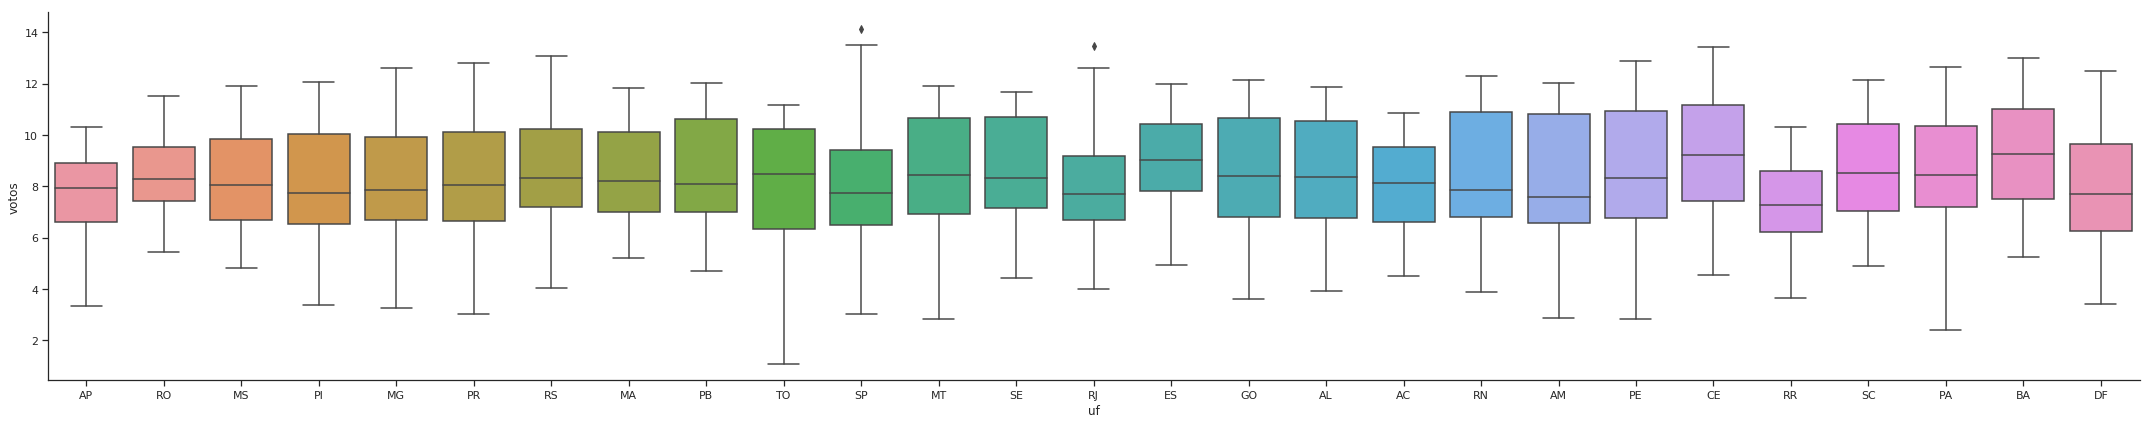

In [149]:
sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

Aqui podemos aplicar uma função e transformar cada estado para um código numérico:

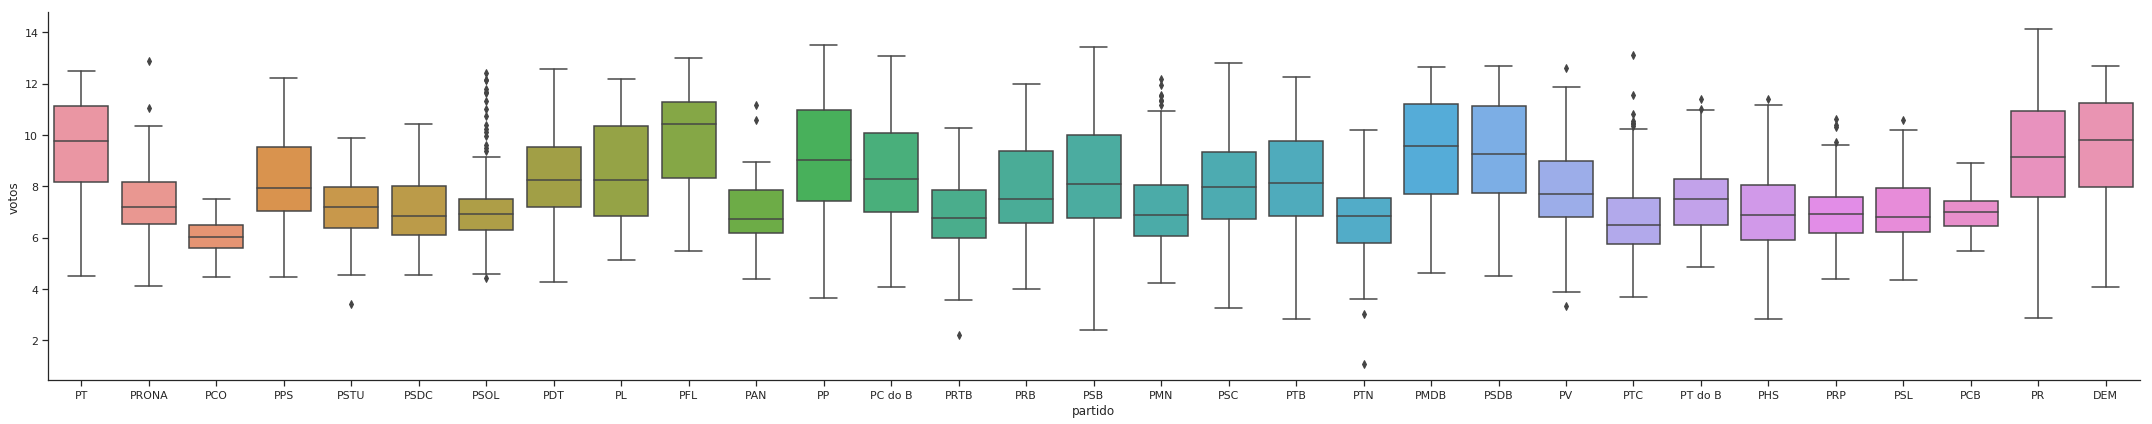

In [150]:
sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

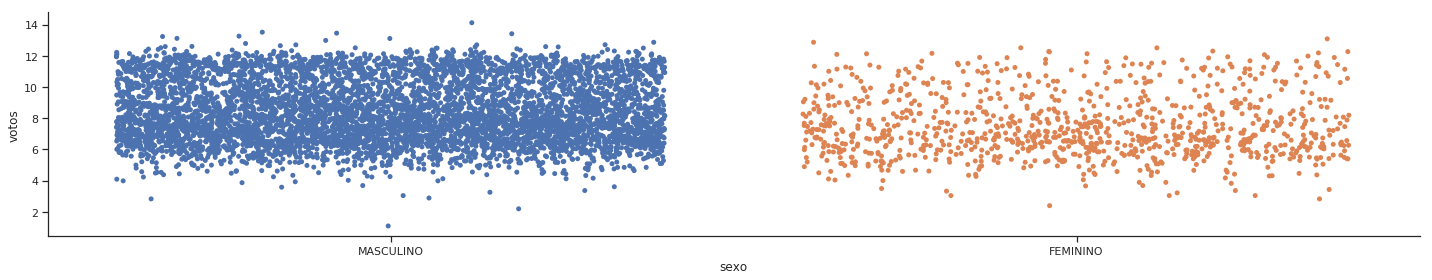

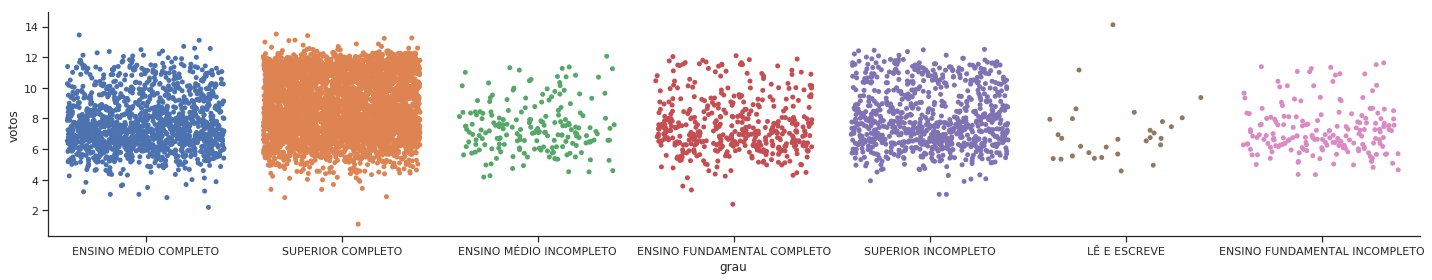

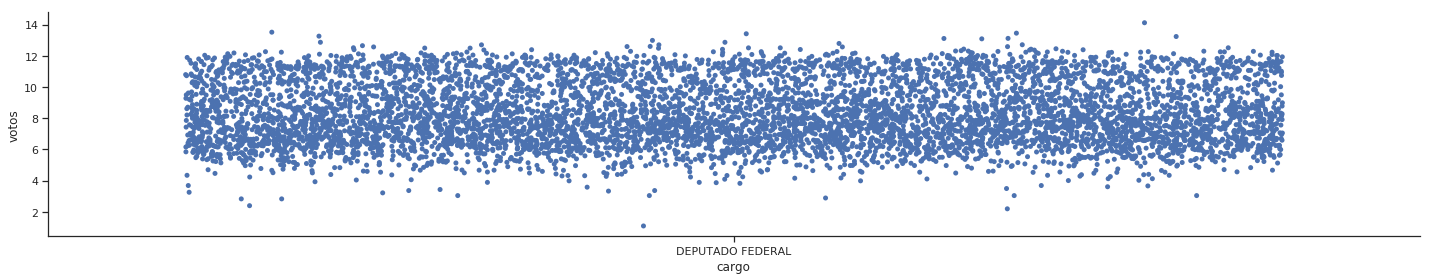

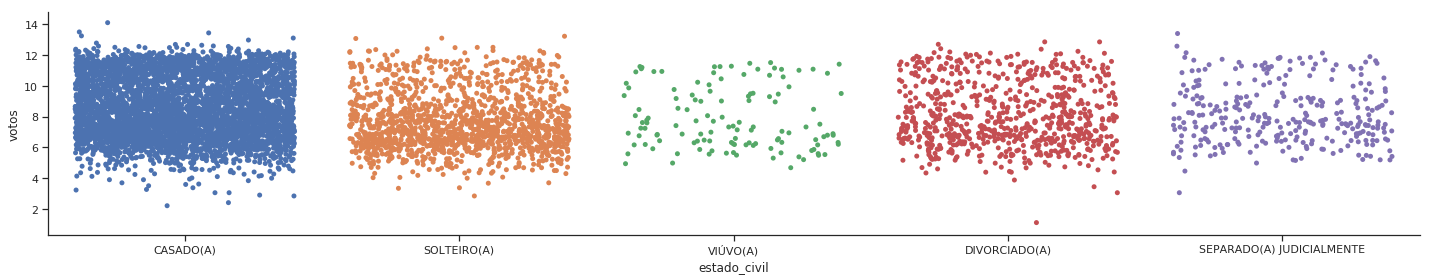

In [151]:
for col in ['sexo', 'grau', 'cargo', 'estado_civil']:
    sns.catplot(x=col, y='votos', data=candidates_df, jitter=.4, aspect=5, height=4)

Note que podemos tratar a variável **grau** como uma variável ordinária:

In [152]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

candidates_df.replace(cleanup_nums, inplace=True)
candidates_test_df.replace(cleanup_nums, inplace=True)

Para a variável **ocupacao** nós temos um conjunto muito grande de diferentes valores, o que inviabiliza a exposição gráfica de todos os valores, entretando nós expomos aqui as quantidades para as 20 ocupações mais comuns:

In [153]:
candidates_df.ocupacao.value_counts().head(10)

OUTROS                       819
DEPUTADO                     703
ADVOGADO                     673
EMPRESÁRIO                   629
VEREADOR                     326
MÉDICO                       325
COMERCIANTE                  316
SERVIDOR PÚBLICO ESTADUAL    248
SERVIDOR PÚBLICO FEDERAL     214
PROFESSOR DE ENSINO MÉDIO    172
Name: ocupacao, dtype: int64

### Dummy Variables

Para transformar essas variáveis categóricas em numéricas (dummy variables), utilizamos uma função especial da biblioteca _pandas_. Contudo nós precisamos concatenar os datasets de treino e validação com o de testes, caso contrário, teremos _features_ que serão modeladas para um dataset e não existirão em outro, o que causa a incompatibilidade e consequentemente a impossibilidade de utilização dos dados de **teste** no modelo gerado com os dados de **treino e validação**.

Antes de criar as variáveis dummy, vamos descobrir quais as quantidade de valores únicos para cada uma das variáveis categóricas que temos em mãos. Assim, nós podemos identificar quais valores de variáveis existem no dataset de _teste_, mas não existem no de _treino e validação_ (**no qual nos baseamos para criarmos o modelo preditor**) e então nós podemos fazer os ajustes necessários.

In [154]:
print("Dataset de Treino e Validação")    
for cat_var in cat_variables:
    print("Variável: {} - Número de Valores Únicos: {}".format(cat_var, candidates_df[cat_var].nunique()))

print()    

print("Dataset de Testes:")
for cat_var in cat_variables_test:
    print("Variável: {} - Número de Valores Únicos: {}".format(cat_var, candidates_test_df[cat_var].nunique()))

Dataset de Treino e Validação
Variável: uf - Número de Valores Únicos: 27
Variável: partido - Número de Valores Únicos: 31
Variável: cargo - Número de Valores Únicos: 1
Variável: sexo - Número de Valores Únicos: 2
Variável: grau - Número de Valores Únicos: 7
Variável: estado_civil - Número de Valores Únicos: 5
Variável: ocupacao - Número de Valores Únicos: 175

Dataset de Testes:
Variável: uf - Número de Valores Únicos: 27
Variável: partido - Número de Valores Únicos: 32
Variável: cargo - Número de Valores Únicos: 1
Variável: sexo - Número de Valores Únicos: 2
Variável: grau - Número de Valores Únicos: 7
Variável: estado_civil - Número de Valores Únicos: 5
Variável: ocupacao - Número de Valores Únicos: 159


Identificando valores de variáveis categóricas presentes no dataset de _testes_ mas não no dataset de _treino e validação_.

In [155]:
dic_catvar_uniques = {}

for cat_var in cat_variables:
    dic_catvar_uniques[cat_var] = set(candidates_df[cat_var].unique())
    set_uni_val_test_dataset = set(candidates_test_df[cat_var].unique())
    dic_catvar_uniques[cat_var] = set_uni_val_test_dataset.union(dic_catvar_uniques[cat_var])

for key,val in dic_catvar_uniques.items():
    print("Variável: {} - Num Unique Values: {}".format(key, len(val)))

Variável: uf - Num Unique Values: 27
Variável: partido - Num Unique Values: 36
Variável: cargo - Num Unique Values: 1
Variável: sexo - Num Unique Values: 2
Variável: grau - Num Unique Values: 7
Variável: estado_civil - Num Unique Values: 5
Variável: ocupacao - Num Unique Values: 192


Como podemos ver, os valores de **partido** e **ocupacao** são as variáveis críticas com as precisamos nos preocupar no momento de fazer o _dummy_ das variáveis categóricas.

In [156]:
print(cat_variables)
candidates_df = pd.get_dummies(data=candidates_df, columns=cat_variables)
candidates_df.shape

['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao']


(7330, 262)

In [160]:
partidos_dummy_cand_df = set([x for x in candidates_df.columns if 'partido' in x])
ocupacao_dummy_cand_df = set([x for x in candidates_df.columns if 'ocupacao' in x])

all_dummy_partidos = set([])
all_unique_partidos = dic_catvar_uniques['partido']
for part in all_unique_partidos:
    all_dummy_partidos.add('partido_' + part)

all_dummy_ocupacao = set([])      
all_unique_ocupacao = dic_catvar_uniques['ocupacao']
for oc in all_unique_ocupacao:
    all_dummy_ocupacao.add('ocupacao_' + oc)

diff_partidos = all_dummy_partidos - partidos_dummy_cand_df
diff_ocupacao = all_dummy_ocupacao - ocupacao_dummy_cand_df

print(diff_partidos)
print(diff_ocupacao)

{'partido_PEN', 'partido_PPL', 'partido_PROS', 'partido_SD', 'partido_PSD'}
{'ocupacao_TÉCNICO DE QUÍMICA', 'ocupacao_BOMBEIRO CIVIL', 'ocupacao_JORNALEIRO', 'ocupacao_ESTOFADOR', 'ocupacao_ECONOMISTA DOMÉSTICO', 'ocupacao_AGENTE DE SERVIÇOS FUNERÁRIOS E EMBALSAMADOR', 'ocupacao_BACTERIOLOGISTA E ASSEMELHADOS', 'ocupacao_METEOROLOGISTA', 'ocupacao_EMPREGADO DOMÉSTICO', 'ocupacao_RELAÇÕES-PÚBLICAS', 'ocupacao_MASSAGISTA', 'ocupacao_CATADOR DE RECICLÁVEIS', 'ocupacao_NUTRICIONISTA E ASSEMELHADOS', 'ocupacao_ATENDENTE DE LANCHONETE E RESTAURANTE', 'ocupacao_MINISTRO DE ESTADO', 'ocupacao_OCEANÓGRAFO', 'ocupacao_GEOFÍSICO'}


Uma vez identificados as variáveis que precisam compor o dataset de treino e validação, nós vamos introduzí-las no dataset de **_treino e validação_** com valor default **0**.

In [161]:
for par in diff_partidos:
    candidates_df[par] = 0

for oc in diff_ocupacao:
    candidates_df[oc] = 0

candidates_df.shape

(7330, 284)

Abaixo vamos criar as variáveis dummy para o dataset de testes:

In [162]:
print(cat_variables_test)
candidates_test_df = pd.get_dummies(data=candidates_test_df, columns=cat_variables_test)
candidates_test_df.shape

['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao']


(4936, 247)

### Distribuição de Variáveis Numéricas

In [ ]:
sns.pairplot(candidates_df, x_vars=['total_despesa', 'total_receita', 'quantidade_doacoes', 'quantidade_fornecedores'], y_vars=['votos'], aspect=1.5, height=4)

In [ ]:
sns.pairplot(candidates_df, x_vars=['recursos_proprios', 'recursos_de_outros_candidatos_comites'], y_vars=['votos'], aspect=2, height=4)

In [ ]:
sns.pairplot(candidates_df, x_vars=['recursos_de_pessoas_juridicas', 'recursos_de_pessoas_fisicas'], y_vars=['votos'], aspect=2, height=4)

## Models

In [ ]:
candidates_train = candidates_df[candidates_df.ano == 2006]
candidates_val = candidates_df[candidates_df.ano == 2010]

feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_train[feats]
y_train = candidates_train['votos']

X_val = candidates_val[feats]
y_val = candidates_val['votos']

Aqui nós vamos usar testar alguns modelos de regressão do scikit-learn em nosso dataset sem usar regularização (ridge e lasso) e em seguida utilizando.

Mas primeiro vamos usar uma função criada por [Alexandru Papiu - Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) para analisar os erros dos modelos propostos. A função utiliza validação cruzada com k = 5 (k-fold validation) e como função de score Negative Mean Squared Error.

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse_cv_val(model):
    rmse = np.sqrt(-cross_val_score(model, X_val, y_val, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Sem Regularização


In [ ]:
lr = LinearRegression().fit(X_train, y_train)
rmse_cv_train(lr).mean()

Média de Erros nos dados de validação

In [ ]:
rmse_cv_val(lr).mean()

Como podemos observar, os valores de RMSE para um modelo linear multivariado sem regularização tem um erro bastante elevado. Isso provavelmente se deve ao fato de está acontecendo overfitting. Uma simples olhada na ordem dos coeficientes do modelo nos permite observar isso. Caso os coeficientes sejam muito grandes, temos overfitting.

In [ ]:
coefs = lr.coef_
ax = sns.distplot(coefs, kde=False)
ax.set(xlabel='Valores dos Coeficientes', ylabel='Quantidade de Coeficientes')
plt.show()

##### **Plot Resíduos vs Predições - Linear Regressor**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
predictions = lr.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo feito com um Linear Regressor sem regularização não é um bom preditor: nós não observamos padrões visuais surgindo na distribuição dos resíduos, o que é um mal indício de adequabilidade do modelo, existem características que não estão sendo corretamente capturadas. E também os pontos estão concentrados aleatoriamente ao redor da linha nula (0).

### Com Regularização

#### Ridge

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge_train = [rmse_cv_train(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge_train = pd.Series(cv_ridge_train, index = alphas)

cv_ridge_train.plot(title = "Training Data")
plt.xlabel("alpha")
plt.ylabel("rmse")

O valor de **alpha** associado com o menor RMSE é **10**. Então vamos utilizar esse valor para configurar nosso modelo de regressão linear Ridge, o qual utiliza normalização **l2**. O valor de RMSE encontrado para alpha = 10 é em torno de 0.928.

In [ ]:
cv_ridge_train.min()

Média dos erros nos dados de validação

In [ ]:
ridge = Ridge(alpha = 10).fit(X_train, y_train)
rmse_cv_val(ridge).mean()

##### **Plot Resíduos vs Predições - Ridge**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
predictions = ridge.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Ridge é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

#### Lasso

In [ ]:
model_lasso = LassoCV(alphas = [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6], max_iter=1e5).fit(X_train, y_train)
rmse_cv_train(model_lasso).mean()

Média dos erros no dados de validação

In [ ]:
rmse_cv_val(model_lasso).mean()

O modelo Lasso se sai um pouco melhor que o modelo Ridge. Complementando a análise, podemos identificar quais variáveis foram consideradas ou eliminadas pelo modelo de regressão Lasso.

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Como podemos ver, o modelo Ridge consegue se sair melhor com o nosso dataset do que o modelo Lasso. O modelo Lasso eliminou um total de 157 variáveis e considerou 104 variáveis como mais importantes.

O gráfico acima também nos permite visualizar que a variável considerada mais relevante para o modelo de predição é **quantidade_doadores**, o que faz bastante sentido. Outra variável também bastante relevante é **ocupacao_DEPUTADO**, o que também faz sentido visto que a pessoa está tentando uma reeleição e provavelmente já é conhecido, tem uma base eleitoral, etc.

Outras variáveis, que o modelo curiosamente considera como uma contribuição negativa para a arrecadação de votos, são **sexo_FEMININO** e **total_receita**. Algumas hipóteses podem ser levantadas, embora ainda se precise de maiores avaliações:

1. Existe uma barreira ou uma resistência quanto à entrada de mulheres na política, isso pode se comprovar na própria composição do nosso congresso nacional, o qual tem um número muito baixo de mulheres;
2. A receita de campanha de um deputado contribui negativamente para a obtenção de votos. Isso é algo que precisa ser investigado em mais profundidade, mas que foge do escopo desse exercício.

##### **Plot Resíduos vs Predições - Lasso**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
predictions = model_lasso.predict(X_val)
sns.residplot(y_val, predictions)

Como vemos, nosso modelo Lasso é um regressor razoável: nós não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo. E também os pontos estão concentrados próximos a linha nula (0).

### Non-Parameterized Models

#### KNN (K-Nearest Neighbors)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors = 15)
reg.fit(X_train, y_train)

predictions_set = reg.predict(X_val)

print("Validation set predictions: \n{}".format(predictions_set))
print("Validation set R²: {:.2f}".format(reg.score(X_val, y_val)))

In [ ]:
training_accuracy = []
val_accuracy = []

neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    knr = KNeighborsRegressor(n_neighbors=n_neighbors)
    knr.fit(X_train, y_train)
    training_accuracy.append(knr.score(X_train, y_train))
    val_accuracy.append(knr.score(X_val, y_val))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, val_accuracy, label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

Aparentemente, o melhor número para K é 15, a partir do qual, os valores de acurácia começam a se repetir. Vamos fazer a análise utilizando as funções para cálculo de RMSE:

In [ ]:
knr = KNeighborsRegressor(n_neighbors = 15).fit(X_train, y_train)

print("RMSE train: {}".format(rmse_cv_train(knr).mean()))
print("RMSE validation: {}".format(rmse_cv_val(knr).mean()))

##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
sns.residplot(y_val, predictions_set)

Como vemos, nosso modelo K-Nearest Regressor não é tão bom, o que é corroborado também pelo valor do R² que é de 0.72, ou seja, apenas 72% da variância dos dados é explicada pelo nosso modelo e pelas variáveis que ele considera. Entretanto, não observamos nenhum padrão visual na distribuição dos resíduos, o que é um bom indício de adequabilidade do modelo.

### Modelos Extra

Nessa sessão vamos testar a eficiência em termos de Precision, Recall e F-Score, quando utilizamos um Ensemble Random Forest Regressor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state = 2).fit(X_train, y_train)

print("RMSE Train: {}".format(rmse_cv_train(regr).mean()))
print("RMSE Validation: {}".format(rmse_cv_val(regr).mean()))
print("R²: {}".format(regr.score(X_val, y_val)))

##### **Plot Resíduos vs Predições - KNN**

Abaixo nós plotamos o gráfico de resíduos vs predições. Ele nos possibilita visualizar o quão eficiente nosso modelo é para capturar a variância de nossos dados e representá-los de maneira adequada. O mais próximo que os valores de resíduos estiverem da linha demarcada (0), melhor será o nosso modelo.

In [ ]:
regr_predictions = regr.predict(X_val)
sns.residplot(y_val, regr_predictions)

Como vemos, nosso modelo **Random Forest Regressor** é tão bom quanto o **KNN** em termos de R², mas em termos de média de RMSE utilizando validação cruzada sobre os dados de validação, **Random Forest Regressor** é o melhor modelo que encontramos até agora.

## EXTRA - Usando Pipelines e GridSearch Scikit Learn

Abaixo nós fazemos alguns pipelines e grid searches com os mesmos algoritmos usados acima com o intuito de checar se os valores obtidos são correspondentes.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Construct some pipelines
pipe_lr = Pipeline([('reg', LinearRegression())])

pipe_rf = Pipeline([('reg', RandomForestRegressor())])

pipe_lasso = Pipeline([('reg', LassoCV())])

pipe_ridge = Pipeline([('reg', RidgeCV())])

pipe_knn = Pipeline([('reg', KNeighborsRegressor())])

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{}] 

grid_params_lasso = [{'reg__alphas' : [[5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5, 1e-6]],
                      'reg__max_iter' : [1e5],
                      'reg__random_state' : [2]}]

grid_params_ridge = [{'reg__alphas' : [[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]]}]

grid_params_rf = [{}]

grid_params_knn = [{'reg__n_neighbors' : [1, 3, 5, 7, 10, 15, 18, 21]}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator = pipe_lr,
                param_grid = grid_params_lr,
                scoring = 'neg_mean_squared_error',
                cv = 5) 

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = 'neg_mean_squared_error',
                cv = 5, 
                n_jobs = jobs)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                       param_grid = grid_params_lasso,
                       scoring = 'neg_mean_squared_error',
                       cv = 5,
                       n_jobs = jobs)

gs_ridge = GridSearchCV(estimator = pipe_ridge,
                       param_grid = grid_params_ridge,
                       scoring = 'neg_mean_squared_error',
                       cv = 5,
                       n_jobs = jobs)

gs_knn = GridSearchCV(estimator = pipe_knn,
                     param_grid = grid_params_knn,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_rf, gs_ridge, gs_lasso, gs_knn]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 
            2: 'Ridge', 3: 'Lasso', 
            4: 'KNN'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = 0.0
best_reg = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best training negative mean squared error: %.3f' % gs.best_score_)
    
    # Predict on test data with best params
    y_pred = gs.predict(X_val)
    
    # Validation data accuracy of model with best params
    print('Validation set RMSE for best params: %.3f ' % mean_squared_error(y_val, y_pred))
    
    # Track best (highest test accuracy) model
    if mean_squared_error(y_val, y_pred) > best_reg:
        best_rmse = mean_squared_error(y_val, y_pred)
        best_gs = gs
        best_reg = idx
        
print('\nClassifier with best validation set RMSE: %s' % grid_dict[best_reg])

Como podemos observar, o resultado obtido diferiu do que obtivemos na análise anterior. Na primeira análise, temos que Random Forests é o algoritmo com melhor desempenho. Já nessa segunda análise, temos que o Ridge é o melhor algoritmo. Isso se deve provavelmente a função de score utilizada no grid search.

## Inserindo Dados de Teste

Abaixo nós vamos unir os dados de treino e validação usados acima, retreinar o melhor algoritmo identificado e usar os dados de teste para verificar seu desempenho em termos de RMSE.

### Load Dataset e Preprocess

In [ ]:
candidates_df_train_test = pd.get_dummies(data=candidates_df_train_test, columns=cat_variables)
candidates_df_train_test.shape

In [ ]:
candidates_train_df_2 = candidates_df_train_test[(candidates_df_train_test.ano == 2006) | (candidates_df_train_test.ano == 2010) ]
candidates_test_df_2 = candidates_df_train_test[candidates_df_train_test.ano == 2014]

feats = candidates_df_train_test.columns[candidates_df_train_test.columns != 'votos']

X_train = candidates_train_df[feats]
y_train = candidates_train_df['votos']

X_test = candidates_test_df[feats]
y_test = candidates_test_df['votos']